## Paper Reading: Rich feature hierarchies for accurate object detection and semantic segmentation Tech report (v5)

### Application
- Object detection: aims to localize and classify objects.
- Semantic segmentation

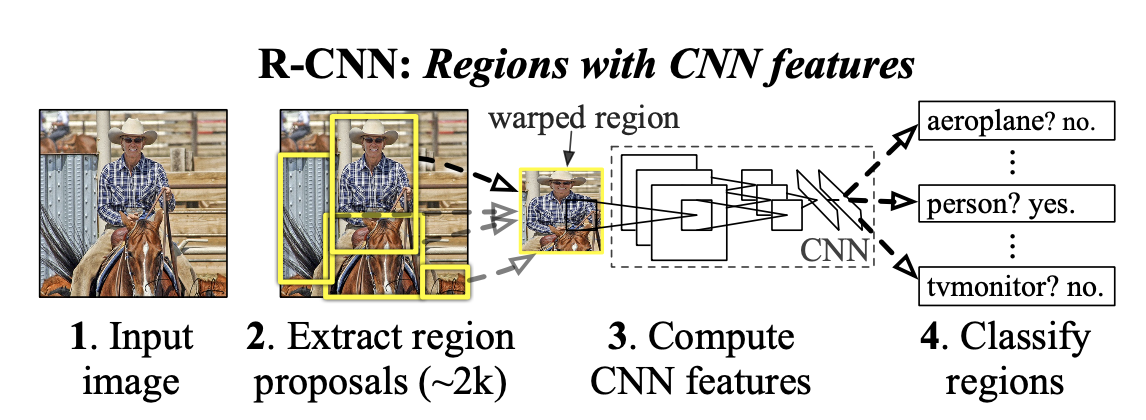

### General Components of RCNN
1. Input Image
  - Problem: the input images are scarce and overfitting
  - Solution: use <u>unsupervised pre-training</u> with large dataset + <u>supervised fine-tuning</u> with small dataset
2. Extracts `region proposals` , then <u>resize</u> them into fixed size by setting `padding=16`.
3. Compute fixed-length features from each region use CNN Network(`AlexNet`)
  - Problem: make up the gap between image classification and object detection
  - Solution: frames localization with only a **small quantity** of annotated detection data. Because object detection requires both positions of detective objects and image classification.
     - one alternative solution is to use `sliding-window`, but it is a challenge to be applied in large and complex CNN model.
4. Classification use `SVMs` for each region
5. use `bounding-box regression` for reducing localization error and classifying objects with probabilistic output.
  - Non-Maximum Suppression(NMS)
  - predict a new detection window given the **pool5 features** for a selective search region proposal.

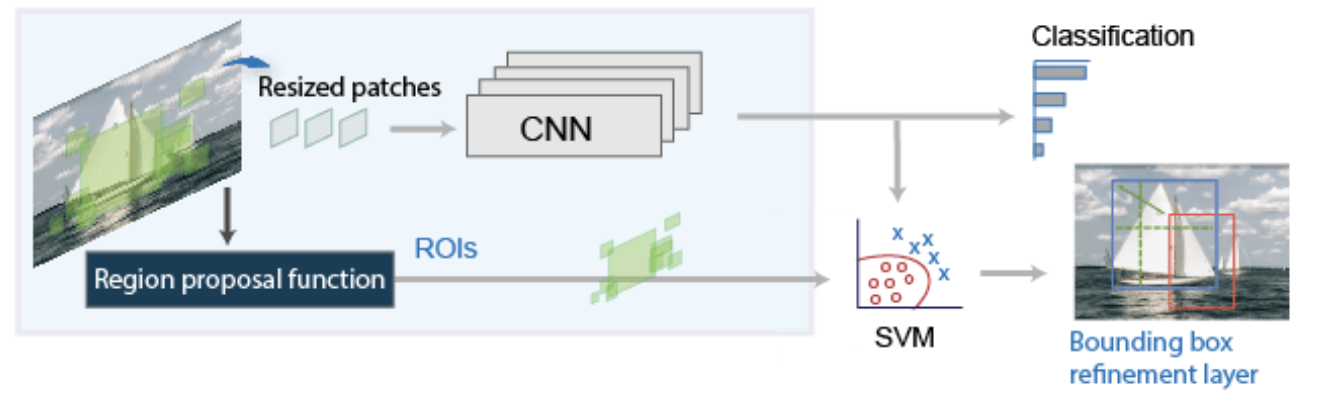

### Model Design

#### Region Proposal
- Use `selective search` to get a controlled comparison with prior detection work.
#### Feature Extraction
- Forward propagation 
- Size=277*277 RGB
- Compute with 5 convolution layers + 2 FC layers (*AlexNet*)
- warp pixels into a tight *bounding box* around it into required size
#### Run-time Analysis
- Tricks to make the model effective:
   1. CNN parameters are shared across all categories.
   2. Generate low-dimensional feature vectors by CNN
#### Training
1. Supervised pre-training
2. Domain-specifc fine-tuning
   - Stochastic Gradient Descent(SGD) to train CNN parameters with wraped region proposals
     - learning rate=0.001
     - batch_size=128
     - sampled 32 positive window and 96 background window
   - use $N+1$ classificiation output layer, where $N$ is number of object classes, $+1$ for background
      - VOC dataset: $N=20$
      - ILSVRC2013 dataset: $N=200$
   - Accuracy Evaluation: 
     - If `IOU`>0.5, give the labels as the <u>box's class</u>, positive. Threshold=0.5
       - IOU: 
         - stands for Intersection over Union
         - Evaluate both correctness of bounding box **locations and labels**. Whether the bounding box is correctly predicted.(Ground Truth VS. Region Proposal predicted by Selective Search)
         - Function: $IOU=\frac{Area of Overlap}{Area of Union}$
         - Meaning: range $[0,1]$, specifies the amount of overlap between the predicted and ground truth bounding box.
            - If $IOU=0$, no overlap between boxes
            - If $IOU=1$, completely overlapping
            - If $IOU>0.5$, the detection is considered to be successful
            - The larger, the better.
     - else, labeled as <u>background</u>, negative.
#### Object Category Classifiers
- Numbers of SVMs=N=Numbers of Category
- Positive Sample: features extracted from ground truth vectors by CNN.
- Negative Sample: background.
- Threshold: $IOU<0.3$, which is much more stricted by the threshold(0.5) of CNN training stage.
- Imbalance Sampling:
  - the number of negative samples>>the number of positive samples, making the training data too large to store in memory
  - Solution: use `standard hard negative mining method`.


       



### Dataset 
- Split into training, validation, testing datasets
  - train set: not wholly annotation, and *cannot* be used for hard negative mining
  - val & test sets: labeled with bounding boxes
- Stategy: heavily rely on val set, for validation and a supplementary source with positive samples for training
   - Divide val set equally into $val1$ and $val2$ for both training and validation
- Boxes: selective search boxes & ground-truth boxes
- $N$ ground-truth boxes per class
- Notation
  - $val_1+train_N$: training data formed a set of images and boxes
  - $val_2$: used for validation and evaluation

### Selective Search
- the number of regions produced depends on image resolution
- The output contains object position information, segmenting inputs into sub-parts.
- Coding: https://pypi.org/project/selective-search/
```
! pip install selective-search
import skimage.io
from selective_search import selective_search
image = skimage.io.imread('path/to/image')
boxes = selective_search(image, mode='single', random_sort=False)
```
- Advantages:
  - Use greedy algorithm, grouping the most similar regions until the whole img is a unique region.
  - Diversity. Use 4 diversification stategies based on color, texture, size, and fill.
     - For each feature, **similarity score** is computed.
     - Do the linear combination work for 4 similarity scores.
  - Computational efficient.
  - finding all the possible locations
  - Use **image structure** to cluster pixels into different regions.

### AlexNet
- Architecture 
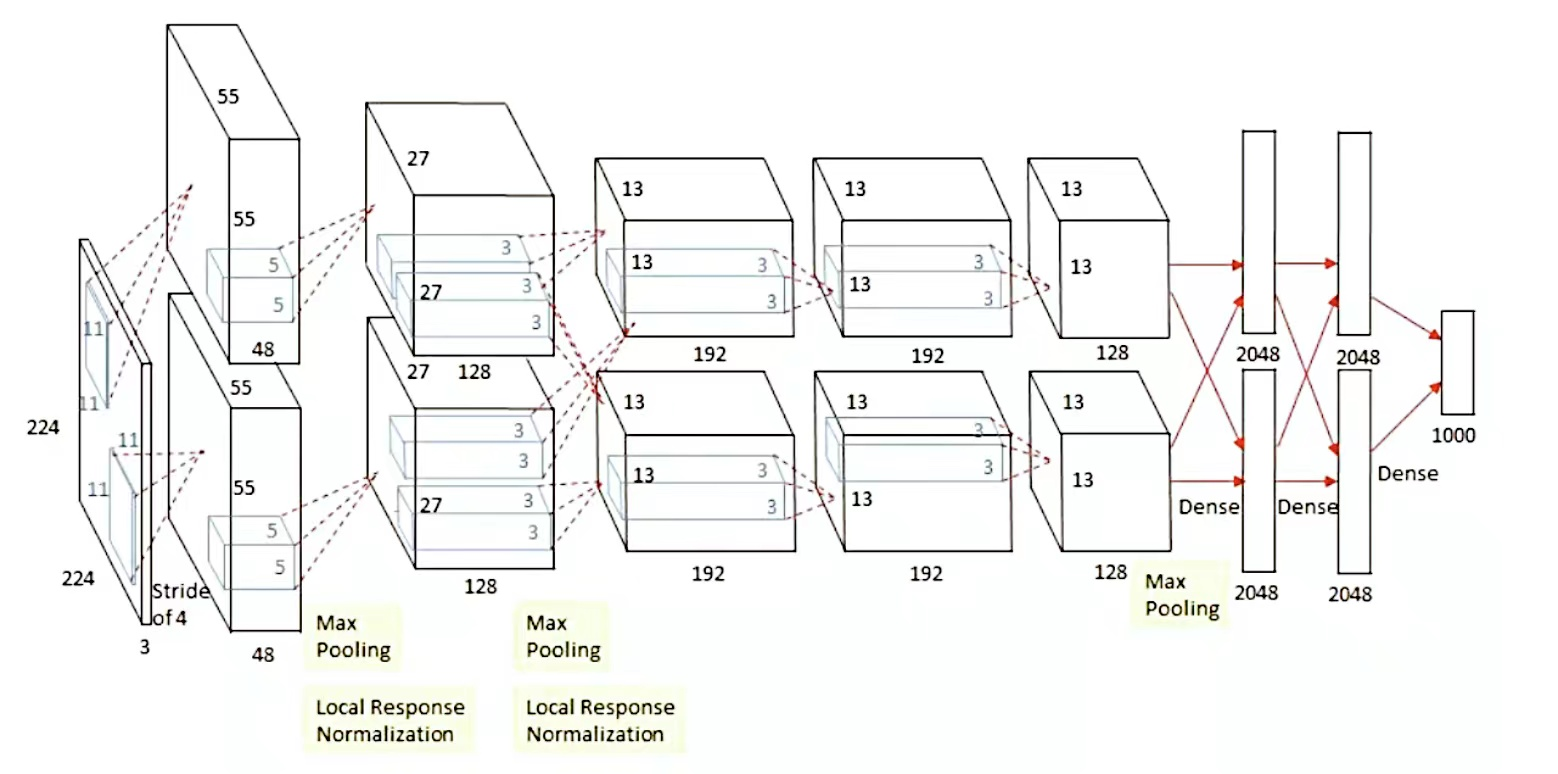

- Use 2 GPU computes simultaneously for the parallel structure, owing to the lack of memory of single GPU.
- Detailed Structure Analysis:
  - Input Layer: Fixed size 224*224*3 RGB images
  - Conv1: kernel_size=11*11, input channel=3, output channel=96, stride=4, padding=2, Output image size=55*55*96
    - Function of Calculating FeatureMap Size: $W_{out}=\frac{W_{in}+2*padding-K}{stride}+1$
      - $K$: kernel
  - MaxPool1:stride=2, kernel=3*3, FeatureMap size=27 * 27 *96
  - Norm1: local_size=5,FeatureMap size=27*27 *96
  - Conv2: stride=1, padding=2, FeatureMap size=27*27*256, kernel_size=(5* 5* 96)*256
  - MaxPool2: stride=2, kernel=3*3, FeatureMap size=13 *13 *256
  - Norm2: local_size=5,FeatureMap size=13 *13 *256
  - ...
  - FC6: Input FeatureMap size=6 *6 *256, Flatten=1 *9216, output FeatureMap size=1 *4096
    - Flatten layer: input shape → <u>one-dimensional array</u>.
  - Dropout6: rate=0.5
  - FC7: Input FeatureMap size=1* 4096, Output FeatureMap size=1*4096
  - Dropout: rate=0.5
  - FC8: Input FeatureMap size=1*4096, Output FeatureMap size=1 *1000
- Use **ReLU activation** for more quick convergence, solving Sigmoid vanishing gradient problem.
- For avoiding overfitting, use dropout trick.
- Connect two paralleled parts together at the final fully connected layer.
- Use Batch Normalization trick, add the stabilization
- Coding with TensorFlow:
```
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
```


### SVM
- handle nonlinear input spaces,deal with both classification and regression problem
- Also known as disciminative classifier.
- The classifier separates data points using a hyperplane in multidimensional space with the largest amount of margin.
- Core Task: find `Maximum Marginal Hyperplane(MMH)`
- Terminology:
  - Support Vector: data points which close to the hyperplane. They will define the separated line by calculating margins.
  - Hyperplane: decision plane, separating between objects having different class memberships.
  - Margin: 
    - a gap between the two lines on the closest class points
    - Calculation: perpendicular distance from the line to support vectors 
    - The larger, the better
- Coding:
```
from sklearn import svm
clf = svm.SVC(kernel='linear') 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
```
- Hyperparameter:
  - Kernel: change the input into the needed format.types: linear, polynomial, and radial basis function (RBF).
  - Regularization($C$): 
    - a penalty parameter, which represents misclassification or error term, telling how much error is bearable.
    - A smaller $C$, creating small-margin hyperplane.
  - Gamma($γ$)
    - a higher value of gamma will exactly fit the training dataset,causing overfitting; While, in reverse, it will cause underfitting.
- Evaluation:
  - higher accuracy and faster computational speed
  - use less memory
  - Not fit for large datasets
  - work sensitive to type of kernel used
  - work poorly for overlapping classes



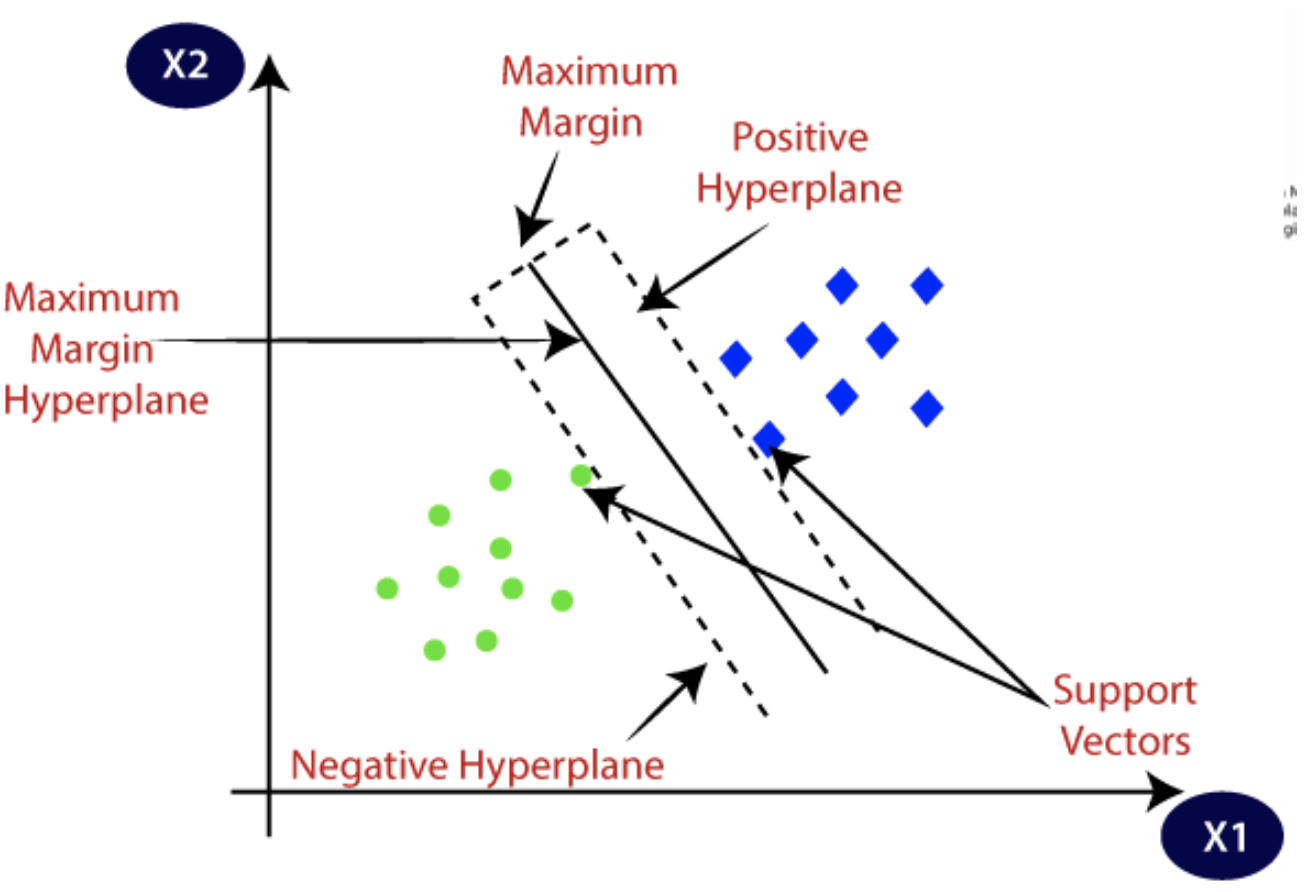

### Detection Evaluation Metric for Object Detection
**Mean Average Precision(mAP)**
- AP: The area under the Precision Recall Curve(AUC), the higher, the more accuracy of detective model performance.
- mAP: the average of APs for all classes and all IOU threshold
  - Range:[0,1]
  - Function: $mAP=\frac{1}{N}∑_{i=1}^N AP_i$
     - $N$: number of classes
  - a trade off between recall and precision
- Use IOU to get *True/False Positive*→TP&FP→calculate recall and precision→get curve and the AUC use derivatives(AP)→mAP
  - False Positive=IOU Threshold
  - True Positive= IOU for prediction
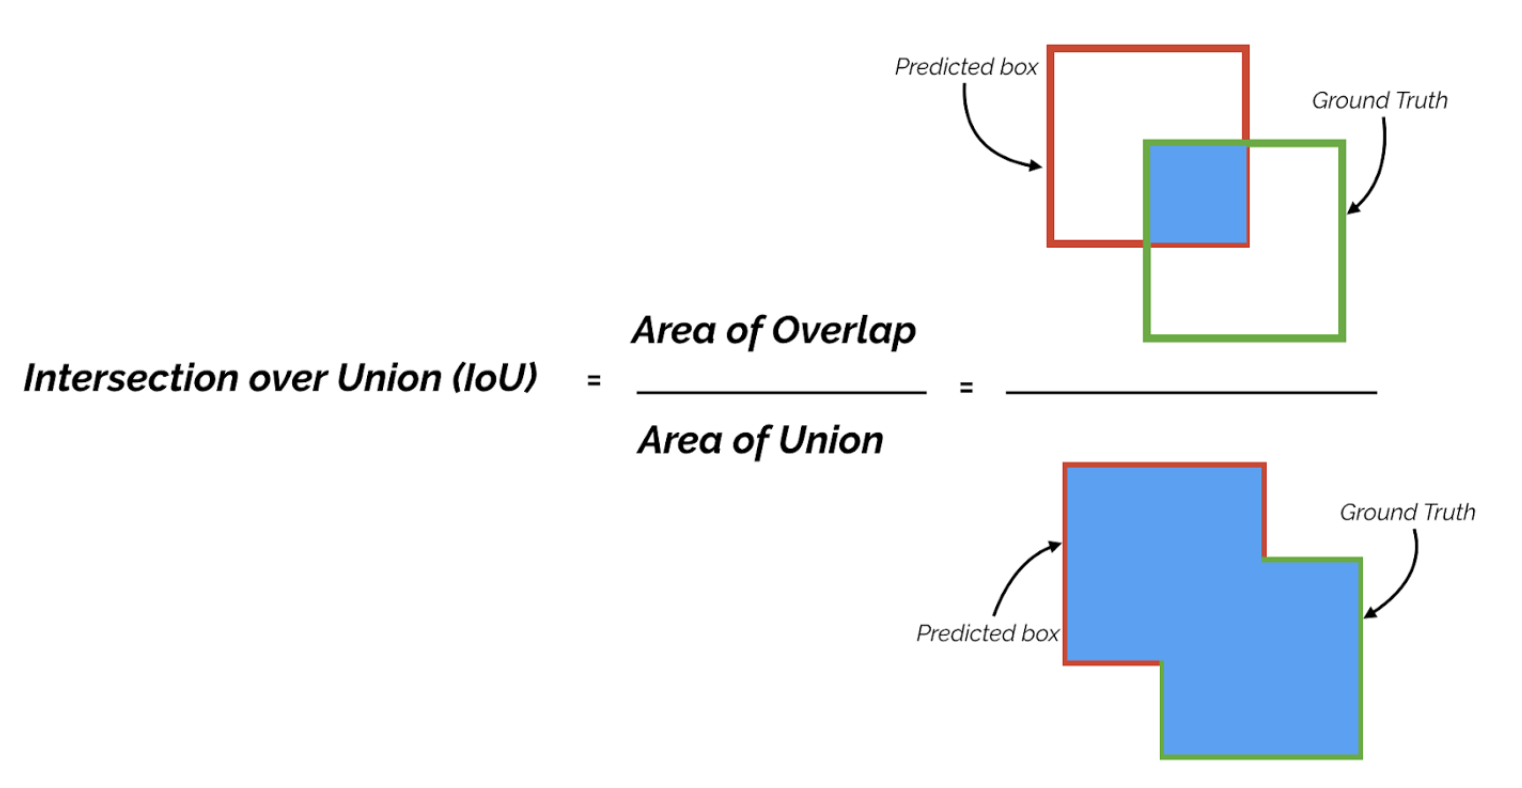


### Standard Hard Negative Mining Method

### References:
- Rich feature hierarchies for accurate object detection and semantic segmentation Tech report (v5).https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
- 从R-CNN到Mask R-CNN.https://zhuanlan.zhihu.com/p/30967656
- R-CNN学习总结.https://zhuanlan.zhihu.com/p/30316608
- Understanding Selective Search for Object Detection.https://medium.com/dataseries/understanding-selective-search-for-object-detection-3f38709067d7
- Support Vector Machines with Scikit-learn Tutorial.https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python
- IoU a better detection evaluation metric.https://medium.com/towards-data-science/iou-a-better-detection-evaluation-metric-45a511185be1
- Selective Search for Object Recognition.https://ivi.fnwi.uva.nl/isis/publications/2013/UijlingsIJCV2013/UijlingsIJCV2013.pdf
- Implementing AlexNet CNN Architecture Using TensorFlow 2.0+ and Keras.https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98
